<a href="https://colab.research.google.com/github/Nahuel023/IM_SMCA/blob/main/SMCA_Correccion_de_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

üïí Muestreo original ‚âà 600 s
Par√°metros de control usados:
 {'set_T': 22.0, 'set_H': 72.0, 'band_T': 2.0, 'band_H': 4.0, 'lock_frio': 600, 'lock_secador': 600, 'lock_humidif': 120, 'humidif_on_time': 300, 'humidif_pwm': True, 'pwm_window': 30, 'k_frio_T': -0.072, 'k_frio_H': -0.2, 'k_secador_H': -1.0, 'k_humidif_H': 0.8, 'k_natural_T': 0.082, 'k_natural_H': 0.1}


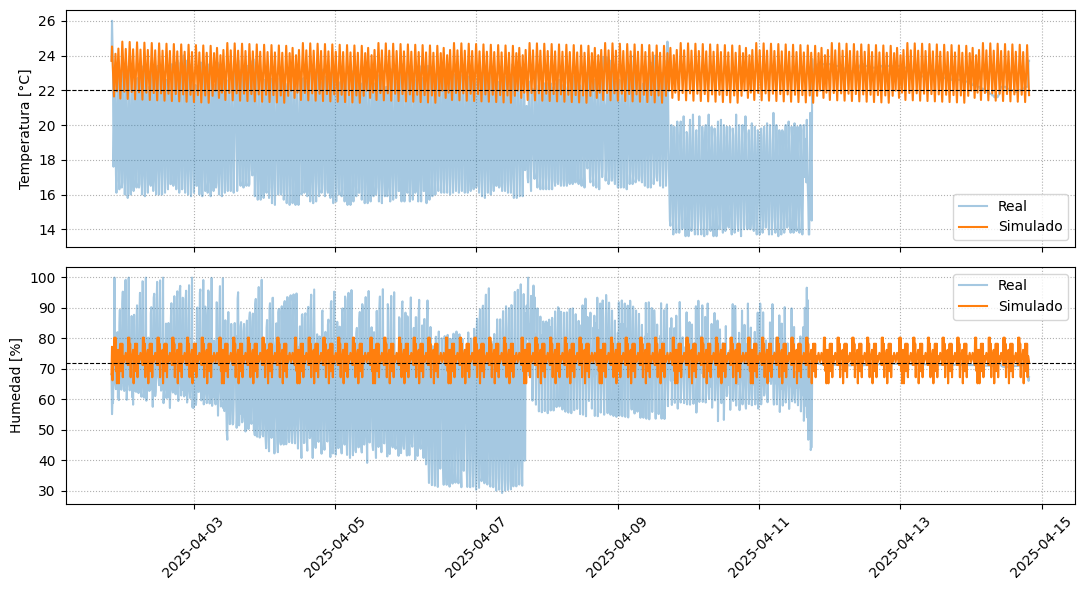

In [ ]:
# ==============================================================
# SMCA ‚Äî Simulador simple para ‚Äújugar‚Äù con par√°metros de control
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# ---------- 1.  Cargar los datos originales -------------------
FILE = '/content/drive/MyDrive/2025/SMCA_Pruebas/DATOS SECADERO 2025 - Sheet1.csv'   # <- cambia si hace falta
raw = (
    pd.read_csv(FILE, skiprows=11, names=['id','datetime','humidity','temperature','x','y'])
      .query('id != "id"')                                           # header repetido
      .assign(datetime=lambda df: pd.to_datetime(df['datetime'],
                                                 format='%d/%m/%Y %H:%M:%S'),
              humidity=lambda df: df['humidity'].str.replace(',','.').astype(float),
              temperature=lambda df: df['temperature'].str.replace(',','.').astype(float))
      .sort_values('datetime')
      .reset_index(drop=True)
)

dt_s = (raw['datetime'].iloc[1] - raw['datetime'].iloc[0]).total_seconds()
print(f'üïí Muestreo original ‚âà {dt_s:.0f} s')

# ---------- 2.  Par√°metros de control que PODEMOS MODIFICAR ----
@dataclass
class ControlParams:
    # consigna
    set_T: float = 20.0        # ¬∞C
    set_H: float = 80.0        # %Hr

    # bandas
    band_T: float = 2.0        # ¬±¬∞C
    band_H: float = 3.0        # ¬±%Hr

    # lock‚Äëouts / tiempos m√≠nimos  (segundos)
    lock_frio: int = 10*60
    lock_secador: int = 10*60
    lock_humidif: int =  2*60

    # duraciones fijas
    humidif_on_time: int = 5*60   # si se usa modo ‚Äúbomba 5 min‚Äù
    humidif_pwm: bool = False     # ‚Üê pon a True para probar modo PWM
    pwm_window: int = 60          # ancho de la ventana PWM (s)

    # modelo din√°mico (pendientes simplificadas)
    k_frio_T: float = -0.072      # ¬∞C por minuto cuando el fr√≠o est√° ON
    k_frio_H: float = -0.20       # %Hr por minuto (descenso aparente)
    k_secador_H: float = -1.0     # %Hr por minuto
    k_humidif_H: float =  0.8     # %Hr por minuto
    k_natural_T: float = +0.082   # ¬∞C por minuto cuando todo est√° OFF
    k_natural_H: float = +0.10    # %Hr por minuto de inercia/filtraciones


params = ControlParams(
    set_T = 22.0,
    set_H = 72.0,
    band_H = 4.0,
    humidif_pwm = True,          # ‚Üê ejemplo: PWM activado
    pwm_window = 30,
)

print('Par√°metros de control usados:\n', asdict(params))

# ---------- 3.  Simulaci√≥n paso a paso -------------------------
n = len(raw)
sim_T = np.empty(n); sim_H = np.empty(n)
relay_frio = False;  relay_sec = False; relay_hum = False
t_last_frio_off = t_last_sec_off = t_last_hum_off = -1e9
hum_on_elapsed = 0

# condiciones iniciales = primeras mediciones reales
sim_T[0], sim_H[0] = raw['temperature'][0], raw['humidity'][0]

for i in range(1, n):
    now = raw['datetime'][i]
    t = (now - raw['datetime'][0]).total_seconds()

    # --- evaluar fr√≠o -------------------------------------------------
    if relay_frio:
        if sim_T[i-1] <= params.set_T:           # hist√©resis inferior
            relay_frio = False
            t_last_frio_off = t
    else:
        if (sim_T[i-1] >= params.set_T + params.band_T
                and t - t_last_frio_off >= params.lock_frio):
            relay_frio = True

    # --- evaluar secador ---------------------------------------------
    if relay_sec:
        if sim_H[i-1] <= params.set_H:
            relay_sec = False
            t_last_sec_off = t
    else:
        if (sim_H[i-1] >= params.set_H + params.band_H
                and t - t_last_sec_off >= params.lock_secador):
            relay_sec = True

    # --- evaluar humidificador ---------------------------------------
    if params.humidif_pwm:           # ‚Üí modo PWM en ventanas
        # duty proporcional al error (muy simple)
        duty = max(0, min(1, (params.set_H - sim_H[i-1]) / params.band_H))
        time_in_window = (t % params.pwm_window)
        relay_hum = (time_in_window < duty * params.pwm_window)
    else:                            # ‚Üí modo ‚Äúbomba 5¬†min‚Äù
        if relay_hum:
            hum_on_elapsed += dt_s
            if (hum_on_elapsed >= params.humidif_on_time
                    or sim_H[i-1] >= params.set_H):
                relay_hum = False
                t_last_hum_off = t
        else:
            if (sim_H[i-1] <= params.set_H - params.band_H
                    and t - t_last_hum_off >= params.lock_humidif):
                relay_hum = True
                hum_on_elapsed = 0

    # --- actualizar din√°mica -----------------------------------------
    dT = params.k_natural_T
    dH = params.k_natural_H
    if relay_frio:
        dT = params.k_frio_T
        dH += params.k_frio_H
    if relay_sec:
        dH += params.k_secador_H
    if relay_hum:
        dH += params.k_humidif_H

    sim_T[i] = sim_T[i-1] + dT * dt_s / 60
    sim_H[i] = sim_H[i-1] + dH * dt_s / 60

# ---------- 4.  Plots -----------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
ax[0].plot(raw['datetime'], raw['temperature'], label='Real', alpha=.4)
ax[0].plot(raw['datetime'], sim_T, label='Simulado', lw=1.5)
ax[0].axhline(params.set_T, color='k', ls='--', lw=.8)
ax[0].set_ylabel('Temperatura [¬∞C]')
ax[0].legend(); ax[0].grid(True, ls=':')

ax[1].plot(raw['datetime'], raw['humidity'], label='Real', alpha=.4)
ax[1].plot(raw['datetime'], sim_H, label='Simulado', lw=1.5)
ax[1].axhline(params.set_H, color='k', ls='--', lw=.8)
ax[1].set_ylabel('Humedad [%]')
ax[1].legend(); ax[1].grid(True, ls=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 5.  Guardar resultado (opcional) -------------------------
# out = raw[['datetime']].copy()
# out['sim_temperature'] = sim_T
# out['sim_humidity']    = sim_H
# out.to_csv('/content/simulated_SMCA.csv', index=False)
# print('CSV con la simulaci√≥n guardado en /content/simulated_SMCA.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

üïí Paso de muestreo de los datos: 600 s
Par√°metros usados:
 {'set_T': 18.0, 'set_H': 80.0, 'band_T': -2, 'band_H': -4, 'lock_frio': 600, 'lock_sec': 600, 'lock_hum': 120, 'k_frio_T': -0.072, 'k_frio_H': -0.2, 'k_sec_H': -1.0, 'k_hum_H': 0.8, 'k_nat_T': 0.082, 'k_nat_H': 0.1, 'pwm_period': 60, 'pwm_duty': 0.5}


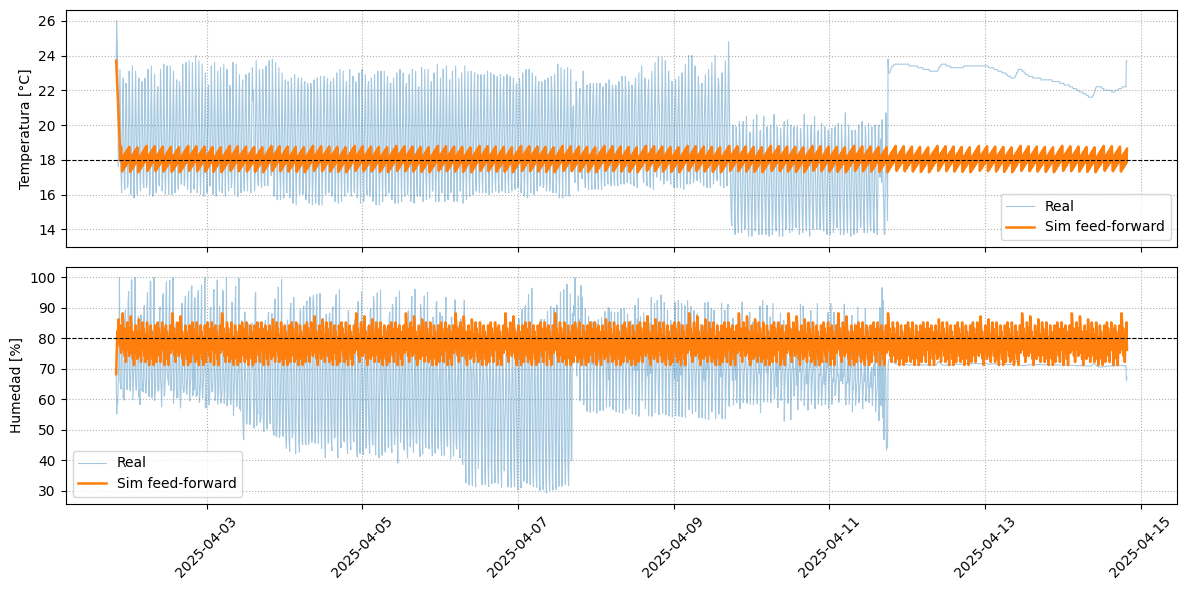


üìù  Interpretaci√≥n r√°pida de las curvas:
    ‚Ä¢ La l√≠nea 'Real' muestra c√≥mo se comport√≥ la c√°mara en tu hist√≥rico.
    ‚Ä¢ La l√≠nea 'Sim feed‚Äëforward' refleja el mismo hist√≥rico pero
      aplicando la l√≥gica FEED‚ÄëFORWARD: cada vez que el fr√≠o est√° ON,
      el humidificador se enciende autom√°ticamente 30 s s√≠ / 30 s no.
    ‚Ä¢ Si el modelo est√° bien calibrado, deber√≠as ver que la curva
      simulada de %Hr ya NO cae a ~40¬†% y tampoco asciende a ~100¬†%.
    ‚Ä¢ Ajusta setpoints o bandas y vuelve a ejecutar para ‚Äòjugar‚Äô
      con diferentes escenarios sin tocar tu firmware real.



In [ ]:
# ==============================================================
#  SMCA ‚Äì Simulaci√≥n con FEED‚ÄëFORWARD de temperatura (estrategia 3.2)
#  --------------------------------------------------------------
#  Idea: Mientras el fr√≠o est√° ON se dispara un ciclo PWM fijo
#        (duty = 50 %, 30 s encendido / 30 s apagado) del
#        humidificador para compensar la ca√≠da aparente de %Hr.
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# ---------- 1) Cargar datos reales ------------------------------------
FILE = '/content/drive/MyDrive/2025/SMCA_Pruebas/DATOS SECADERO 2025 - Sheet1.csv'  # ‚Üê ajusta ruta si hace falta
raw = (
    pd.read_csv(FILE, skiprows=11,
                names=['id','datetime','humidity','temperature','x','y'])
      .query('id != "id"')                           # elimina fila extra de cabecera
      .assign(datetime=lambda df: pd.to_datetime(df['datetime'],
                                                 format='%d/%m/%Y %H:%M:%S'),
              humidity=lambda df: df['humidity'].str.replace(',','.').astype(float),
              temperature=lambda df: df['temperature'].str.replace(',','.').astype(float))
      .sort_values('datetime')
      .reset_index(drop=True)
)

# Paso de muestreo real (segundos) ‚Äì lo usaremos para escalar pendientes
dt_s = (raw['datetime'].iloc[1] - raw['datetime'].iloc[0]).total_seconds()
print(f'üïí Paso de muestreo de los datos: {dt_s:.0f} s')

# ---------- 2) Par√°metros del controlador -----------------------------
@dataclass
class Params:
    # consignas
    set_T: float = 18.0     # ¬∞C
    set_H: float = 80.0     # %Hr

    # bandas de hist√©resis
    band_T: float = -2     # ¬±¬∞C
    band_H: float = -4     # ¬±%Hr

    # lock‚Äëouts (segundos) para proteger compresor y resistencias
    lock_frio: int = 10*60
    lock_sec:  int = 10*60
    lock_hum:  int = 2*60

    # par√°metros del modelo de c√°mara (pendientes simplificadas)
    k_frio_T: float = -0.072   # ¬∞C/min cuando fr√≠o ON
    k_frio_H: float = -0.20    # %Hr/min ca√≠da aparente por enfriar
    k_sec_H : float = -1.0     # %Hr/min que quita el secador
    k_hum_H : float =  0.8     # %Hr/min que a√±ade el humidificador
    k_nat_T : float = +0.082   # ¬∞C/min recalentamiento natural
    k_nat_H : float = +0.10    # %Hr/min incremento natural de humedad

    # ------- par√°metros espec√≠ficos de feed‚Äëforward -------------------
    pwm_period: int = 60       # longitud de la ventana PWM (s)
    pwm_duty  : float = 0.5    # 50 %  ‚Üí 30 s ON / 30 s OFF


P = Params()   # instancia ‚Äì puedes cambiar valores y re‚Äëejecutar
print('Par√°metros usados:\n', asdict(P))

# ---------- 3) Arrays para la simulaci√≥n ------------------------------
n = len(raw)
sim_T = np.empty(n); sim_H = np.empty(n)

# Estados de rel√© (bool) y marcas temporales (s)
relay_frio = relay_sec = relay_hum = False
t_last_frio_off = t_last_sec_off = t_last_hum_off = -1e9

# Condici√≥n inicial = primera medici√≥n real
sim_T[0], sim_H[0] = raw['temperature'][0], raw['humidity'][0]

# ---------- 4) Bucle de simulaci√≥n paso a paso ------------------------
#  Recorremos todas las filas del CSV y, para cada instante,
#  aplicamos la l√≥gica ON/OFF + FEED‚ÄëFORWARD
for i in range(1, n):
    # Tiempo absoluto (s) desde el comienzo de la serie
    t_abs = (raw['datetime'][i] - raw['datetime'][0]).total_seconds()

    # -------- 4.1  L√ìGICA DEL REL√â DE FR√çO ----------------------------
    if relay_frio:
        if sim_T[i-1] <= P.set_T:                # banda inferior
            relay_frio = False
            t_last_frio_off = t_abs
    else:
        if (sim_T[i-1] >= P.set_T + P.band_T and
            t_abs - t_last_frio_off >= P.lock_frio):
            relay_frio = True

    # -------- 4.2  L√ìGICA DEL REL√â DE SECADOR -------------------------
    if relay_sec:
        if sim_H[i-1] <= P.set_H:                # banda inferior
            relay_sec = False
            t_last_sec_off = t_abs
    else:
        if (sim_H[i-1] >= P.set_H + P.band_H and
            t_abs - t_last_sec_off >= P.lock_sec):
            relay_sec = True

    # -------- 4.3  FEED‚ÄëFORWARD DE HUMIDIFICADOR ----------------------
    #  Mientras el FR√çO est√° encendido trabajamos en PWM fijo 50 %:
    #  - El periodo completo es pwm_period (60 s)
    #  - Humidificador ON en la primera mitad de la ventana
    if relay_frio:
        time_in_window = t_abs % P.pwm_period
        relay_hum = (time_in_window < P.pwm_period * P.pwm_duty)
    #  Cuando el fr√≠o est√° OFF volvemos a la l√≥gica habitual:
    else:
        if relay_hum:
            # Apagar si ya estamos en banda o sobre‚Äëhumedecidos
            if sim_H[i-1] >= P.set_H:
                relay_hum = False
                t_last_hum_off = t_abs
        else:
            # Encender si estamos por debajo de la banda y pasaron 2 min
            if (sim_H[i-1] <= P.set_H - P.band_H and
                t_abs - t_last_hum_off >= P.lock_hum):
                relay_hum = True

    # -------- 4.4  DIN√ÅMICA DE LA C√ÅMARA ------------------------------
    #  Sumamos las pendientes correspondientes.  Las conversiones
    #  /60 son para pasar de "por minuto" ‚Üí "por dt_s segundos"
    dT = P.k_nat_T
    dH = P.k_nat_H
    if relay_frio:
        dT = P.k_frio_T
        dH += P.k_frio_H
    if relay_sec:
        dH += P.k_sec_H
    if relay_hum:
        dH += P.k_hum_H

    sim_T[i] = sim_T[i-1] + dT * dt_s / 60
    sim_H[i] = sim_H[i-1] + dH * dt_s / 60

# ---------- 5) Graficar resultado -------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- Temperatura
ax[0].plot(raw['datetime'], raw['temperature'],
           label='Real', alpha=0.4, lw=0.8)
ax[0].plot(raw['datetime'], sim_T,
           label='Sim feed‚Äëforward', lw=1.8)
ax[0].axhline(P.set_T, ls='--', c='k', lw=.8)
ax[0].set_ylabel('Temperatura [¬∞C]')
ax[0].legend(); ax[0].grid(ls=':')

# --- Humedad
ax[1].plot(raw['datetime'], raw['humidity'],
           label='Real', alpha=0.4, lw=0.8)
ax[1].plot(raw['datetime'], sim_H,
           label='Sim feed‚Äëforward', lw=1.8)
ax[1].axhline(P.set_H, ls='--', c='k', lw=.8)
ax[1].set_ylabel('Humedad [%]')
ax[1].legend(); ax[1].grid(ls=':')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 6) ¬øQu√© estoy viendo? -------------------------------------
print("""
üìù  Interpretaci√≥n r√°pida de las curvas:
    ‚Ä¢ La l√≠nea 'Real' muestra c√≥mo se comport√≥ la c√°mara en tu hist√≥rico.
    ‚Ä¢ La l√≠nea 'Sim feed‚Äëforward' refleja el mismo hist√≥rico pero
      aplicando la l√≥gica FEED‚ÄëFORWARD: cada vez que el fr√≠o est√° ON,
      el humidificador se enciende autom√°ticamente 30 s s√≠ / 30 s no.
    ‚Ä¢ Si el modelo est√° bien calibrado, deber√≠as ver que la curva
      simulada de %Hr ya NO cae a ~40¬†% y tampoco asciende a ~100¬†%.
    ‚Ä¢ Ajusta setpoints o bandas y vuelve a ejecutar para ‚Äòjugar‚Äô
      con diferentes escenarios sin tocar tu firmware real.
""")
